# OD Distance Prediction for the Working Tracts in NYC Metro Region

In this part, we want to predict the OD distance for each working district. With the model, we can know what will attract people to do long commutes.

In [1]:
import requests
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd
import requests
import hvplot.pandas

np.random.seed(42)

In [2]:
pd.options.display.max_columns = 999

## 1. Data Loading

The first step is to load the dataset we need. It mostly come from three source:
- **LODES:** age; income; type of industry; number of jobs (The statistics are shown below） 
- **GEOGRAPHY:** County/borough & geometry
- **ACS:** Median housing price; owner rate; population density 
These features show strong spatial correlation and we will use them to predict the OD distance.

Plus, since the LODES data is calculated by tract, to get the OD distance, we will try to calculate the centroid distance of different tracts.

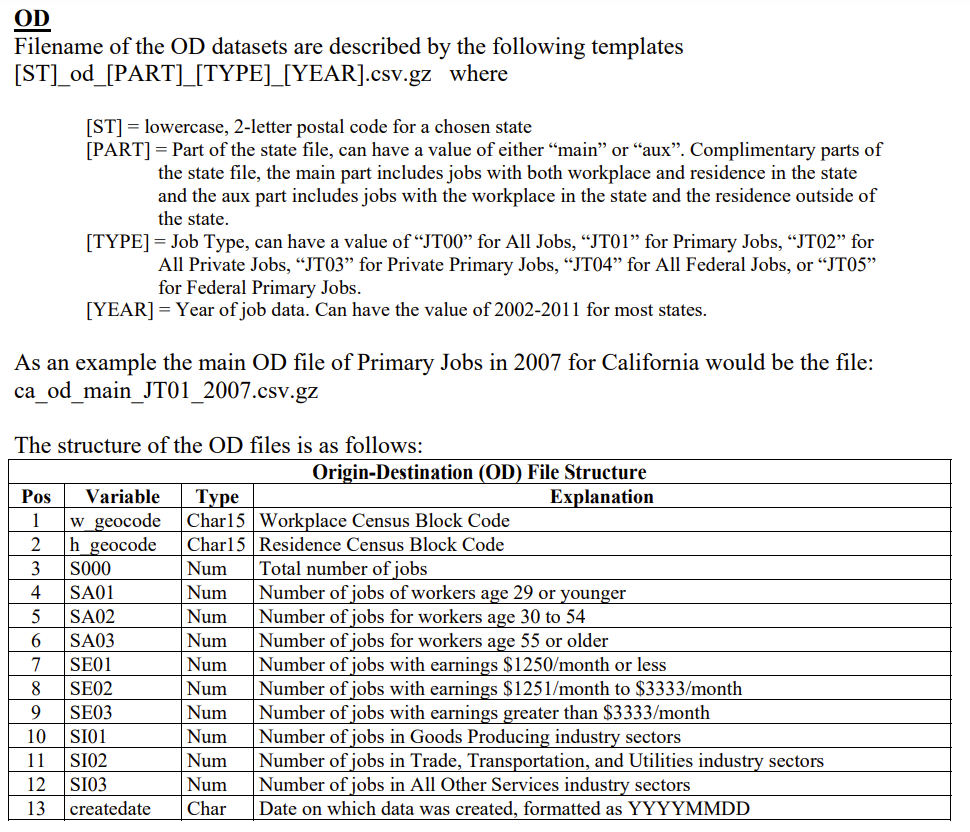

In [3]:
from IPython.display import Image, display
# Path to your image file
image_path = 'Pic/LODES_Directory.png'

# Set the width and height you want
width = 600
height = 600

# Display the image with specified width and height
display(Image(filename=image_path, width=600, height=400))

In [4]:
# Specify the output CSV file path
output_csv_path = 'Data_git/LODES/Home_Job/'
ct_home_job_2021 = pd.read_csv(output_csv_path + 'HOME_JOB_2021.csv')
ct_home_job_2019 = pd.read_csv(output_csv_path + 'HOME_JOB_2019.csv')

In [5]:
ct_home_job_2021.head()

w_geocode_ct  h_geocode_ct  S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
0   34017000200   34017000200    13     0    10     3     1    11     1     0   
1   34017000200   34017000300     1     0     0     1     0     0     1     0   
2   34017000200   34017000400     2     0     2     0     0     0     2     0   
3   34017000200   34017000500     1     0     0     1     1     0     0     0   
4   34017000200   34017000700     4     3     0     1     0     2     2     0   

   SI02  SI03  
0     4     9  
1     0     1  
2     0     2  
3     0     1  
4     1     3

In [6]:
lod_ml = ct_home_job_2021[['w_geocode_ct','S000']]
lod_ml = lod_ml.rename(columns = {'S000': "job"})
lod_ml = lod_ml.groupby('w_geocode_ct')['job'].sum().reset_index()
lod_ml.head()

w_geocode_ct  job
0   34017000200   78
1   34017000300   75
2   34017000400  712
3   34017000500   68
4   34017000600  150

In [7]:
od_final = gpd.read_file("./Data_git/LODES/OD_Final/OD_final_2021.csv")

In [8]:
od_final['w_geocode_ct'] = od_final['w_geocode_ct'].astype('int64')

In [9]:
od_final.head()

w_geocode_ct h_geocode_ct S000             SA01_Pct            SA02_Pct  \
0   34017000200  34017000200   11  0.18181818181818182  0.2727272727272727   
1   34017000200  34017000500    2                  0.0                 1.0   
2   34017000200  34017000700    2                  1.0                 0.0   
3   34017000200  34017000800    2                  0.0                 1.0   
4   34017000200  34017000902    2                  1.0                 0.0   

             SA03_Pct             SE01_Pct            SE02_Pct SE03_Pct  \
0  0.5454545454545454  0.18181818181818182  0.8181818181818182      0.0   
1                 0.0                  0.0                 1.0      0.0   
2                 0.0                  0.5                 0.5      0.0   
3                 0.0                  1.0                 0.0      0.0   
4                 0.0                  0.0                 1.0      0.0   

  SI01_Pct            SI02_Pct            SI03_Pct geometry  
0      0.0  0.2727272727272727  0.7272727272727273     None  
1      0.0                 0.0                 1.0     None  
2      0.0                 0.5                 0.5     None  
3      0.0                 0.0                 1.0     None  
4      0.0                 1.0                 0.0     None

In [10]:
od = od_final

In [11]:
od_feature = ["S000", "SA01_Pct","SA02_Pct", "SA03_Pct", 'SE01_Pct', 'SE02_Pct', 'SE03_Pct','SI01_Pct', 'SI02_Pct', 'SI03_Pct']

In [12]:
od_feature.extend(["w_geocode_ct", "h_geocode_ct"])

# Apply rounding only to columns specified in od_feature
od_final[od_feature] = od_final[od_feature].applymap(lambda x: round(float(x), 2) if isinstance(x, (int, float, str)) else x)

In [13]:
od.head()

w_geocode_ct  h_geocode_ct  S000  SA01_Pct  SA02_Pct  SA03_Pct  SE01_Pct  \
0  3.401700e+10  3.401700e+10  11.0      0.18      0.27      0.55      0.18   
1  3.401700e+10  3.401700e+10   2.0      0.00      1.00      0.00      0.00   
2  3.401700e+10  3.401700e+10   2.0      1.00      0.00      0.00      0.50   
3  3.401700e+10  3.401700e+10   2.0      0.00      1.00      0.00      1.00   
4  3.401700e+10  3.401700e+10   2.0      1.00      0.00      0.00      0.00   

   SE02_Pct  SE03_Pct  SI01_Pct  SI02_Pct  SI03_Pct geometry  
0      0.82       0.0       0.0      0.27      0.73     None  
1      1.00       0.0       0.0      0.00      1.00     None  
2      0.50       0.0       0.0      0.50      0.50     None  
3      0.00       0.0       0.0      0.00      1.00     None  
4      1.00       0.0       0.0      1.00      0.00     None

In [14]:
from shapely.geometry import Point
import pandas as pd

In [15]:
# We have processed the geographical data
# You can load the NYC Metro Region geographical data on census tract directly
metro_geojson_path = 'Data_git/Geo/metro.geojson'
metro_gdf = gpd.read_file(metro_geojson_path)
metro_gdf.head()

GEOID COUNTYFP                                           geometry
0  36061001501      061  POLYGON ((981865.515 198455.903, 981935.654 19...
1  36061001600      061  POLYGON ((984941.947 199431.109, 985056.156 19...
2  36061001800      061  POLYGON ((985796.223 201370.479, 985808.416 20...
3  36061002000      061  POLYGON ((990149.045 201586.466, 990284.254 20...
4  36061002201      061  POLYGON ((988552.924 201677.942, 988733.850 20...

In [16]:
metro_gdf['centroid'] = metro_gdf['geometry'].centroid
metro_gdf.head()

GEOID COUNTYFP                                           geometry  \
0  36061001501      061  POLYGON ((981865.515 198455.903, 981935.654 19...   
1  36061001600      061  POLYGON ((984941.947 199431.109, 985056.156 19...   
2  36061001800      061  POLYGON ((985796.223 201370.479, 985808.416 20...   
3  36061002000      061  POLYGON ((990149.045 201586.466, 990284.254 20...   
4  36061002201      061  POLYGON ((988552.924 201677.942, 988733.850 20...   

                        centroid  
0  POINT (983800.739 197130.851)  
1  POINT (986116.768 200118.951)  
2  POINT (986788.960 201244.639)  
3  POINT (991778.422 201349.682)  
4  POINT (989282.797 201270.261)

In [17]:
metro_gdf['GEOID'] = metro_gdf['GEOID'].astype('int64')

In [18]:
od1 = pd.merge(od, metro_gdf, left_on='w_geocode_ct', right_on='GEOID', how='left')
od1 = od1.rename(columns = {'centroid': "centroid_w"})
od1 = od1[["w_geocode_ct","h_geocode_ct", "centroid_w"]]

od1.head()

w_geocode_ct  h_geocode_ct                     centroid_w
0  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)
1  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)
2  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)
3  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)
4  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)

In [19]:
od2 = pd.merge(od, metro_gdf, left_on='h_geocode_ct', right_on='GEOID', how='left')
od2 = od2.rename(columns = {'centroid': "centroid_h"})
od2 = od2[["w_geocode_ct","h_geocode_ct", "centroid_h"]]
od2.head()

w_geocode_ct  h_geocode_ct                     centroid_h
0  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)
1  3.401700e+10  3.401700e+10  POINT (970028.592 212498.393)
2  3.401700e+10  3.401700e+10  POINT (971242.247 211122.304)
3  3.401700e+10  3.401700e+10  POINT (972050.016 210369.447)
4  3.401700e+10  3.401700e+10  POINT (966966.631 208869.177)

In [20]:
merged_gdf = pd.merge(od1, od2, left_on = ['w_geocode_ct', 'h_geocode_ct'], right_on=['w_geocode_ct', 'h_geocode_ct'], how='left')

merged_gdf.head()

w_geocode_ct  h_geocode_ct                     centroid_w  \
0  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
1  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
2  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
3  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
4  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   

                      centroid_h  
0  POINT (971257.758 213719.041)  
1  POINT (970028.592 212498.393)  
2  POINT (971242.247 211122.304)  
3  POINT (972050.016 210369.447)  
4  POINT (966966.631 208869.177)

In [21]:
merged_gdf['centroid_distance'] = merged_gdf.apply(lambda row: row['centroid_h'].distance(row['centroid_w']), axis=1)

In [22]:
merged_gdf = merged_gdf.rename(columns = {'centroid_distance': "OD_dis"})
merged_gdf.head()

w_geocode_ct  h_geocode_ct                     centroid_w  \
0  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
1  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
2  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
3  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   
4  3.401700e+10  3.401700e+10  POINT (971257.758 213719.041)   

                      centroid_h       OD_dis  
0  POINT (971257.758 213719.041)     0.000000  
1  POINT (970028.592 212498.393)  1732.290484  
2  POINT (971242.247 211122.304)  2596.783100  
3  POINT (972050.016 210369.447)  3442.012248  
4  POINT (966966.631 208869.177)  6475.719654

In [23]:
merged_gdf = merged_gdf[["w_geocode_ct", "h_geocode_ct", "OD_dis"]]

In [24]:
od_ml = pd.merge(merged_gdf, od, left_on = ['w_geocode_ct', 'h_geocode_ct'], right_on=['w_geocode_ct', 'h_geocode_ct'], how='left')
od_ml = od_ml.drop(["geometry"], axis=1)
od_ml.head()

w_geocode_ct  h_geocode_ct       OD_dis  S000  SA01_Pct  SA02_Pct  \
0  3.401700e+10  3.401700e+10     0.000000  11.0      0.18      0.27   
1  3.401700e+10  3.401700e+10  1732.290484   2.0      0.00      1.00   
2  3.401700e+10  3.401700e+10  2596.783100   2.0      1.00      0.00   
3  3.401700e+10  3.401700e+10  3442.012248   2.0      0.00      1.00   
4  3.401700e+10  3.401700e+10  6475.719654   2.0      1.00      0.00   

   SA03_Pct  SE01_Pct  SE02_Pct  SE03_Pct  SI01_Pct  SI02_Pct  SI03_Pct  
0      0.55      0.18      0.82       0.0       0.0      0.27      0.73  
1      0.00      0.00      1.00       0.0       0.0      0.00      1.00  
2      0.00      0.50      0.50       0.0       0.0      0.50      0.50  
3      0.00      1.00      0.00       0.0       0.0      0.00      1.00  
4      0.00      0.00      1.00       0.0       0.0      1.00      0.00

In [25]:
len(od_ml)

1260007

ACS data will show the owner rate, house balue and population density, which are important for our study.

In [26]:
data = pd.read_csv('Data_git/CSV/acs21_data.csv')

In [27]:
data.head()

GEOID  COUNTYFP                                           geometry  \
0  36061001501        61  POLYGON ((981865.5151276055 198455.90345435744...   
1  36061001600        61  POLYGON ((984941.9468926088 199431.108577446, ...   
2  36061001800        61  POLYGON ((985796.222567258 201370.4793967813, ...   
3  36061002000        61  POLYGON ((990149.0445261953 201586.46616041855...   
4  36061002201        61  POLYGON ((988552.9238458973 201677.94219388932...   

       area                                           NAME  21 population  \
0  0.761081  Census Tract 15.01, New York County, New York           7749   
1  0.361350     Census Tract 16, New York County, New York           8133   
2  0.388537     Census Tract 18, New York County, New York           7271   
3  0.460328     Census Tract 20, New York County, New York           5015   
4  0.281718  Census Tract 22.01, New York County, New York           6689   

   21 total householder  21 owner householder  21 renter householder  \
0                  7290                  4254                   3036   
1                  7950                  1263                   6687   
2                  6666                   635                   6031   
3                  4994                    60                   4934   
4                  6521                   847                   5674   

   21 meidan housing value  state  county  tract   pop_density  own_rate  \
0                   767300     36      61   1501  10181.574978  0.583539   
1                   668200     36      61   1600  22507.261055  0.158868   
2                   748100     36      61   1800  18713.780639  0.095260   
3               -666666666     36      61   2000  10894.415408  0.012014   
4               -666666666     36      61   2201  23743.599946  0.129888   

   rent_rate  
0   0.416461  
1   0.841132  
2   0.904740  
3   0.987986  
4   0.870112

In [28]:
acs_ml = data[['GEOID','pop_density', 'own_rate', '21 meidan housing value','geometry']]
acs_ml = acs_ml[acs_ml['21 meidan housing value'] >= 0]
acs_ml = acs_ml.rename(columns = {"21 meidan housing value": "meidan_housing_value"})
acs_ml.head()

GEOID   pop_density  own_rate  meidan_housing_value  \
0  36061001501  10181.574978  0.583539                767300   
1  36061001600  22507.261055  0.158868                668200   
2  36061001800  18713.780639  0.095260                748100   
5  36061002202  24770.084463  0.052083                597800   
7  36061002601  22568.674204  0.132255                642600   

                                            geometry  
0  POLYGON ((981865.5151276055 198455.90345435744...  
1  POLYGON ((984941.9468926088 199431.108577446, ...  
2  POLYGON ((985796.222567258 201370.4793967813, ...  
5  POLYGON ((988759.896978163 202177.4772083543, ...  
7  POLYGON ((989094.0677459151 202786.702712106, ...

In [29]:
data_ml = pd.merge(acs_ml, od_ml, left_on='GEOID', right_on='h_geocode_ct', how='left')
data_ml.head()

GEOID   pop_density  own_rate  meidan_housing_value  \
0  36061001501  10181.574978  0.583539                767300   
1  36061001501  10181.574978  0.583539                767300   
2  36061001501  10181.574978  0.583539                767300   
3  36061001501  10181.574978  0.583539                767300   
4  36061001501  10181.574978  0.583539                767300   

                                            geometry  w_geocode_ct  \
0  POLYGON ((981865.5151276055 198455.90345435744...  3.401700e+10   
1  POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
2  POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
3  POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
4  POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   

   h_geocode_ct        OD_dis  S000  SA01_Pct  SA02_Pct  SA03_Pct  SE01_Pct  \
0  3.606100e+10  23441.025413   1.0      0.00      0.00       1.0       0.0   
1  3.606100e+10  12733.684796   1.0      1.00      0.00       0.0       0.0   
2  3.606100e+10  16894.563308   1.0      0.00      1.00       0.0       0.0   
3  3.606100e+10   8433.961315  15.0      0.73      0.27       0.0       0.0   
4  3.606100e+10  10849.374650   1.0      0.00      0.00       1.0       0.0   

   SE02_Pct  SE03_Pct  SI01_Pct  SI02_Pct  SI03_Pct  
0       1.0       0.0       0.0       0.0       1.0  
1       1.0       0.0       0.0       0.0       1.0  
2       0.0       1.0       0.0       1.0       0.0  
3       0.0       1.0       0.0       0.0       1.0  
4       0.0       1.0       0.0       0.0       1.0

In [30]:
len(data_ml)

1125030

In [31]:
data_ml = data_ml.dropna()

## 2. Feature Engineering

Based on the dataset we got in the first step, we finally choose the following features:

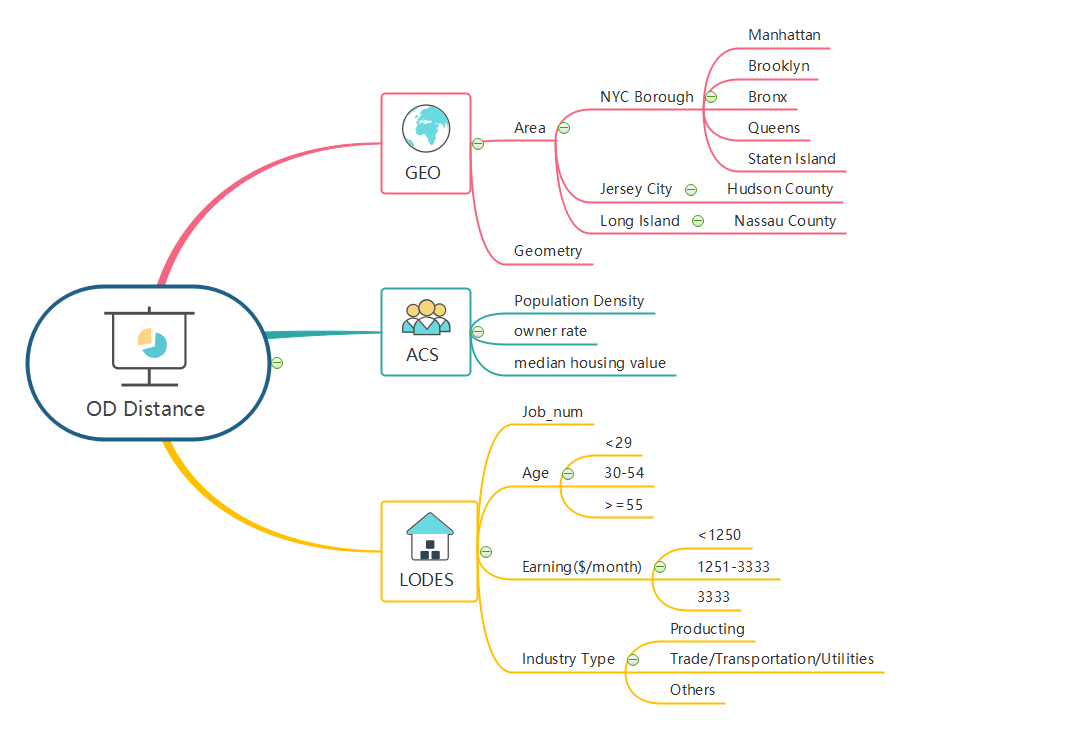

In [32]:
from IPython.display import Image, display
# Path to your image file
image_path = 'Pic/ML_Variable.png'

# Display the image with specified width and height
display(Image(filename=image_path, width=800, height=600))

In [33]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [34]:
# Split the data 70/30
train_set, test_set = train_test_split(data_ml, test_size=0.3, random_state=42)

In [35]:
# Replace zero or negative values with a small positive value
epsilon = 1e-6
train_set['OD_dis'] = train_set['OD_dis'].apply(lambda x: epsilon if x <= 0 else x)
test_set['OD_dis'] = test_set['OD_dis'].apply(lambda x: epsilon if x <= 0 else x)

# Recalculate the log
y_train = np.log(train_set["OD_dis"])
y_test = np.log(test_set["OD_dis"])

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [37]:
data_ml2 = pd.merge(acs_ml, od_ml, left_on='GEOID', right_on='h_geocode_ct', how='left')

In [38]:
import numpy as np
# Convert 'GEOID' to string if it's not already
data_ml2['GEOID'] = data_ml2['GEOID'].astype(str)

# Define a function to identify tracts based on GEOID
def identify_tract(geoid):
    nyc_counties = {'061': 'Manhattan', '047': 'Brooklyn', '005': 'Bronx', '081': 'Queens', '085': 'Staten Island'}
    outside_nyc_counties = {'017': 'Jersey City', '059': 'Long Island'}

    # Extract COUNTYFP and STATEFP from the GEOID
    county_fp = geoid[2:5]
    state_code = geoid[:2]

    if county_fp in nyc_counties:
        return nyc_counties[county_fp]
    elif county_fp in outside_nyc_counties and state_code == '34':
        return outside_nyc_counties[county_fp]
    else:
        return np.nan  # or any other value to indicate not in specified areas

# Create a new column 'Borough' using the identify_tract function
data_ml2['Borough'] = data_ml2['GEOID'].apply(identify_tract)


In [39]:
data_ml2

GEOID   pop_density  own_rate  meidan_housing_value  \
0        36061001501  10181.574978  0.583539                767300   
1        36061001501  10181.574978  0.583539                767300   
2        36061001501  10181.574978  0.583539                767300   
3        36061001501  10181.574978  0.583539                767300   
4        36061001501  10181.574978  0.583539                767300   
...              ...           ...       ...                   ...   
1125025  34017006700   2680.744587  0.198102                279300   
1125026  34017006700   2680.744587  0.198102                279300   
1125027  34017006700   2680.744587  0.198102                279300   
1125028  34017006700   2680.744587  0.198102                279300   
1125029  34017006700   2680.744587  0.198102                279300   

                                                  geometry  w_geocode_ct  \
0        POLYGON ((981865.5151276055 198455.90345435744...  3.401700e+10   
1        POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
2        POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
3        POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
4        POLYGON ((981865.5151276055 198455.90345435744...  3.401701e+10   
...                                                    ...           ...   
1125025  POLYGON ((968961.8738765337 201950.28349582435...  3.608500e+10   
1125026  POLYGON ((968961.8738765337 201950.28349582435...  3.608501e+10   
1125027  POLYGON ((968961.8738765337 201950.28349582435...  3.608501e+10   
1125028  POLYGON ((968961.8738765337 201950.28349582435...  3.608503e+10   
1125029  POLYGON ((968961.8738765337 201950.28349582435...  3.608503e+10   

         h_geocode_ct        OD_dis  S000  SA01_Pct  SA02_Pct  SA03_Pct  \
0        3.606100e+10  23441.025413   1.0      0.00      0.00       1.0   
1        3.606100e+10  12733.684796   1.0      1.00      0.00       0.0   
2        3.606100e+10  16894.563308   1.0      0.00      1.00       0.0   
3        3.606100e+10   8433.961315  15.0      0.73      0.27       0.0   
4        3.606100e+10  10849.374650   1.0      0.00      0.00       1.0   
...               ...           ...   ...       ...       ...       ...   
1125025  3.401701e+10  31589.591418   1.0      0.00      1.00       0.0   
1125026  3.401701e+10  48135.323263   1.0      0.00      1.00       0.0   
1125027  3.401701e+10  34492.213017   1.0      1.00      0.00       0.0   
1125028  3.401701e+10  49836.427686   1.0      0.00      1.00       0.0   
1125029  3.401701e+10  53712.404128   3.0      0.33      0.67       0.0   

         SE01_Pct  SE02_Pct  SE03_Pct  SI01_Pct  SI02_Pct  SI03_Pct  \
0             0.0       1.0       0.0      0.00      0.00       1.0   
1             0.0       1.0       0.0      0.00      0.00       1.0   
2             0.0       0.0       1.0      0.00      1.00       0.0   
3             0.0       0.0       1.0      0.00      0.00       1.0   
4             0.0       0.0       1.0      0.00      0.00       1.0   
...           ...       ...       ...       ...       ...       ...   
1125025       0.0       1.0       0.0      1.00      0.00       0.0   
1125026       0.0       0.0       1.0      0.00      0.00       1.0   
1125027       0.0       0.0       1.0      1.00      0.00       0.0   
1125028       0.0       1.0       0.0      0.00      0.00       1.0   
1125029       0.0       0.0       1.0      0.33      0.67       0.0   

             Borough  
0          Manhattan  
1          Manhattan  
2          Manhattan  
3          Manhattan  
4          Manhattan  
...              ...  
1125025  Jersey City  
1125026  Jersey City  
1125027  Jersey City  
1125028  Jersey City  
1125029  Jersey City  

[1125030 rows x 19 columns]

In [40]:
data_ml2 = data_ml2.dropna()

In [41]:
# Split the data 70/30
train_set2, test_set2 = train_test_split(data_ml2, test_size=0.3, random_state=42)

In [42]:
# Replace zero or negative values with a small positive value
epsilon = 1e-6
train_set2['OD_dis'] = train_set2['OD_dis'].apply(lambda x: epsilon if x <= 0 else x)
test_set2['OD_dis'] = test_set2['OD_dis'].apply(lambda x: epsilon if x <= 0 else x)

# Recalculate the log
y_train2 = np.log(train_set2["OD_dis"])
y_test2 = np.log(test_set2["OD_dis"])

In [45]:
# Set up a pipeline that includes both numerical columns and categorical columns
# Numerical columns
num_cols2 = [
   'pop_density', 
    'own_rate', 
    'meidan_housing_value',
    "S000", 
    "SA01_Pct",
    "SA02_Pct", 
    "SA03_Pct", 
    'SE01_Pct', 
    'SE02_Pct', 
    'SE03_Pct',
    'SI01_Pct', 
    'SI02_Pct', 
    'SI03_Pct'
]

# Categorical columns
cat_cols2 = ["Borough"]

A correlation matrix was created to examined the correlation between those numerical variables.

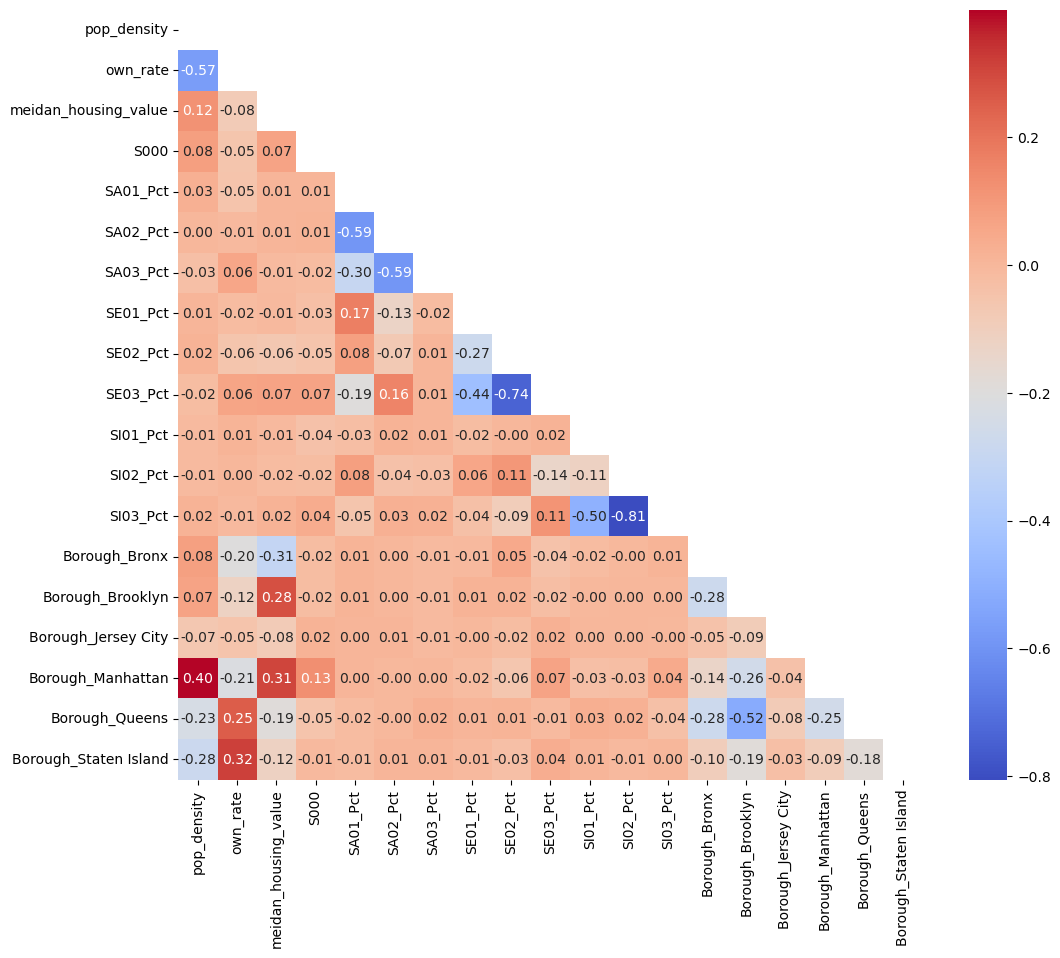

In [70]:
import seaborn as sns

# Select the relevant columns from the DataFrame
selected_cols = num_cols2 + cat_cols2
df_selected = data_ml2[selected_cols]

# Convert categorical columns to numerical using one-hot encoding
df_selected = pd.get_dummies(df_selected, columns=cat_cols2)

# Create a correlation matrix
correlation_matrix = df_selected.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap using seaborn with the mask
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)

# Show the plot
plt.show()


## 3. Modeling & Important Features

In our current project, our team employed a **RandomForest model** to delve into the essential features influencing OD_distance (Origin-Destination distance). This analysis aims to illuminate the intricate relationship between job locations and communities. Specifically, we intend to showcase the OD distance based on the working places, offering a clearer understanding of how job distribution correlates with community dynamics.

To further improve the model, we used cross-validation to find the best model. After the find the best model, we calculated the predicted od distance, percent error for each working tract.

In [46]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols2),
    ]
)

In [47]:
# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
pipe2 = make_pipeline(
    transformer2, RandomForestRegressor(n_estimators=10, 
                                       random_state=42)
)

In [48]:
# Fit the training set
pipe2.fit(train_set2, y_train2);

In [49]:
# What's the test score?
pipe2.score(test_set2, y_test2)

0.150099372075283

In [50]:
# The one-hot step
ohe2 = transformer2.named_transformers_['cat']

ohe2

OneHotEncoder(handle_unknown='ignore')

In [51]:
# One column for each category type!
ohe_cols2 = ohe2.get_feature_names_out()

ohe_cols2

array(['Borough_Bronx', 'Borough_Brooklyn', 'Borough_Jersey City',
       'Borough_Manhattan', 'Borough_Queens', 'Borough_Staten Island'],
      dtype=object)

In [52]:
# Full list of columns is numerical + one-hot 
features2 = num_cols2 + list(ohe_cols2)

features2

['pop_density',
 'own_rate',
 'meidan_housing_value',
 'S000',
 'SA01_Pct',
 'SA02_Pct',
 'SA03_Pct',
 'SE01_Pct',
 'SE02_Pct',
 'SE03_Pct',
 'SI01_Pct',
 'SI02_Pct',
 'SI03_Pct',
 'Borough_Bronx',
 'Borough_Brooklyn',
 'Borough_Jersey City',
 'Borough_Manhattan',
 'Borough_Queens',
 'Borough_Staten Island']

In [53]:
random_forest2 = pipe2["randomforestregressor"]

# Create the dataframe with importances
importance2 = pd.DataFrame(
    {"Feature": features2, "Importance": random_forest2.feature_importances_}
).sort_values("Importance", ascending= False)

In [54]:
importance2

Feature  Importance
3                    S000    0.122677
2    meidan_housing_value    0.107925
0             pop_density    0.101593
1                own_rate    0.096939
10               SI01_Pct    0.081886
9                SE03_Pct    0.078152
4                SA01_Pct    0.064901
6                SA03_Pct    0.057649
12               SI03_Pct    0.056036
8                SE02_Pct    0.049624
7                SE01_Pct    0.046288
5                SA02_Pct    0.046168
11               SI02_Pct    0.042303
18  Borough_Staten Island    0.014788
16      Borough_Manhattan    0.008722
14       Borough_Brooklyn    0.007243
13          Borough_Bronx    0.007007
17         Borough_Queens    0.006851
15    Borough_Jersey City    0.003246

The graph indicates that the most crucial factors are the number of jobs, median housing value, and population density. This aligns with our initial hypothesis, as these features somewhat mirror the job market, worker incomes, and housing prices.

Regarding geography, Staten Island and Manhattan hold more significance. This suggests that the model might perform better or be more applicable to these areas.

In [55]:
importance2.hvplot.barh(x="Feature", y="Importance", title="Feature Importances")

:Bars   [Feature]   (Importance)

In [57]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [10, 20, 30],
    f"{model_name}__max_depth": [None, 5,10],
}

param_grid

{'randomforestregressor__n_estimators': [10, 20, 30],
 'randomforestregressor__max_depth': [None, 5, 10]}

In [58]:
# Create the grid and use 5-fold CV (10-fold is too slow for my laptop)
grid = GridSearchCV(pipe2, param_grid, cv=5, n_jobs=2)

In [62]:
# Run the search
grid.fit(train_set2, y_train2);

In [63]:
grid.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 30}

In [68]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
scores = grid.score(test_set2, y_test2)

The final reslut for the best model's R^2 is 0.24225978969870154, this is not so high because the LODES data are not precise figure but just intervals. However, the importance of features still make sense to our research.

In [69]:
# The data here could be shown
print("R^2 scores = ", scores)

R^2 scores =  0.24225978969870154


In [65]:
original = data_ml2.loc[test_set2.index]

In [71]:
# Predictions for log of total trip counts
predictions2 = best_random.predict(test_set2)

# Convert the predicted test values from log
percent_error2 = ((np.exp(predictions2) - np.exp(y_test2))/ (np.exp(y_test2))) * 100

In [72]:
original['predicted_OD'] = np.exp(predictions2)
original['pct_error']  = percent_error2
original.head()

GEOID   pop_density  own_rate  meidan_housing_value  \
66666   36061020800  22011.444612  0.228232               1207000   
444288  36005014100  20613.862080  0.089562                329500   
53562   36061027900  36225.450408  0.038058                467500   
405800  36047056900   7901.226769  0.335443               1677100   
723352  36081055400   7262.672430  0.494118                591300   

                                                 geometry  w_geocode_ct  \
66666   POLYGON ((999603.3881490915 234048.3103714518,...  3.401700e+10   
444288  POLYGON ((1007473.6161408128 239799.0583322422...  3.608103e+10   
53562   POLYGON ((1002434.2403219667 250995.5821085846...  3.608101e+10   
405800  POLYGON ((996534.9494471189 203031.60740555753...  3.606100e+10   
723352  POLYGON ((1055241.1272265045 204986.3706797314...  3.606101e+10   

        h_geocode_ct        OD_dis  S000  SA01_Pct  SA02_Pct  SA03_Pct  \
66666   3.606102e+10  38459.279421   2.0      0.00      1.00       0.0   
444288  3.600501e+10  29356.810386   4.0      0.50      0.50       0.0   
53562   3.606103e+10  62421.032520   1.0      0.00      1.00       0.0   
405800  3.604706e+10  13086.389174   6.0      0.17      0.83       0.0   
723352  3.608106e+10  64358.897959   2.0      0.00      0.50       0.5   

        SE01_Pct  SE02_Pct  SE03_Pct  SI01_Pct  SI02_Pct  SI03_Pct    Borough  \
66666        0.0      0.00      1.00       0.0      0.50      0.50  Manhattan   
444288       0.0      0.50      0.50       0.0      0.00      1.00      Bronx   
53562        0.0      0.00      1.00       0.0      0.00      1.00  Manhattan   
405800       0.0      0.17      0.83       0.0      0.17      0.83   Brooklyn   
723352       0.0      0.00      1.00       0.0      0.00      1.00     Queens   

        predicted_OD  pct_error  
66666   22550.296698 -41.365785  
444288  28522.215991  -2.842933  
53562   35426.207150 -43.246361  
405800  18463.202203  41.087064  
723352  30912.374885 -51.968763

In [73]:
grouped2 = original.groupby("w_geocode_ct")["pct_error"].median().reset_index()
grouped2.head()

w_geocode_ct   pct_error
0  3.401700e+10  254.385251
1  3.401700e+10   27.010603
2  3.401700e+10  -28.238708
3  3.401700e+10   -0.575975
4  3.401700e+10  -14.232894

In [74]:
grouped2 = grouped2.rename(columns={'pct_error': 'med_pct_error'})

In [75]:
error_by_tract2 = pd.merge(grouped2, metro_gdf, left_on='w_geocode_ct', right_on='GEOID', how='left')
error_by_tract2.head()

w_geocode_ct  med_pct_error        GEOID COUNTYFP  \
0  3.401700e+10     254.385251  34017000200      017   
1  3.401700e+10      27.010603  34017000300      017   
2  3.401700e+10     -28.238708  34017000400      017   
3  3.401700e+10      -0.575975  34017000500      017   
4  3.401700e+10     -14.232894  34017000600      017   

                                            geometry  \
0  POLYGON ((972281.250 214323.331, 972242.429 21...   
1  POLYGON ((973518.354 211958.244, 973287.579 21...   
2  POLYGON ((969536.448 213341.497, 969513.437 21...   
3  POLYGON ((971287.839 212435.141, 971209.900 21...   
4  POLYGON ((970943.622 211759.854, 970842.935 21...   

                        centroid  
0  POINT (971257.758 213719.041)  
1  POINT (972459.098 212644.110)  
2  POINT (968055.224 212445.827)  
3  POINT (970028.592 212498.393)  
4  POINT (969578.803 211126.904)

We find that the distribution of model errors is very regionally characterized. Overall, the model predictions in the kings and Queens districts are skewed high, while most of the other districts are skewed low. This is related to the residential character of the Kings, Queens districts, which, due to their positioning, results in these two districts not having a large number of jobs. 

Additionally, Manhattan Island has a low overall error and generally has lower predicted values than true values. This is due to the fact that Manhattan Island is one of the core areas for employment in New York and has a higher job attraction for citizens.

In [76]:
error_by_tract2 = gpd.GeoDataFrame(error_by_tract2, geometry='geometry')
error_by_tract2 = error_by_tract2[["GEOID", "med_pct_error", "geometry"]]

import folium
# Create a Folium map centered around the mean of the geometry
n = error_by_tract2.explore(
    column="med_pct_error",  # Specify the value column
    cmap="coolwarm",  # Use coolwarm colormap
    tiles="CartoDB positron",  # Specify basemap tiles
    vmin=-100,  # Adjust the minimum value for the colormap based on your data
    vmax=100,   # Adjust the maximum value for the colormap based on your data
    style_kwds={
    "weight": 1,  # Adjust the outline thickness
    }
)

# Add a title
title_html = '<h3 align="center" style="font-size:20px"><b>2021 NYC Metro Area model pct of error</b></h3>'
n.get_root().html.add_child(folium.Element(title_html))

# Show the map
n

## 4 Extra Exploration: will the subway have an effect on our project?

In addition, since OD distance is not exactly equal to commuting distance, the local transportation facilities in the area will also have a greater impact on OD distance. So, our team want to explore if there is the relationship between the percentage of error in our model and the subway station distribution because if there is a local subway station, it means an increase in commuting capacity, which may attract more people who commute in from far away.

In this step, our team mainly choose the station data from NYC.

In [77]:
# API endpoint URL
transportation_api_url = 'https://data.ny.gov/resource/i9wp-a4ja.json'

# Make a GET request to the API
response = requests.get(transportation_api_url)

In [78]:
if response.status_code == 200:
    # Parse the JSON data
    transportation_data = response.json()

    # Convert the JSON data to a DataFrame
    transportation_df = pd.DataFrame(transportation_data)

In [79]:
transportation_df.head()

division      line borough          station_name station_latitude  \
0      IND  Rockaway       Q  Far Rockaway-Mott Av        40.603995   
1      IND  Rockaway       Q         Beach 25th St        40.600066   
2      IND  Rockaway       Q         Beach 25th St        40.600066   
3      IND  Rockaway       Q         Beach 25th St        40.600066   
4      IND  Rockaway       Q         Beach 36th St        40.595398   

  station_longitude daytime_routes entrance_type entry exit_only vending  \
0        -73.755405              A          Door   YES        NO     YES   
1        -73.761353              A         Stair   YES        NO     YES   
2        -73.761353              A         Stair   YES        NO     YES   
3        -73.761353              A         Stair   YES        NO     YES   
4        -73.768175              A         Stair   YES        NO     YES   

  staffing north_south_street east_west_street corner entrance_latitude  \
0     FULL      Beach 22nd St         Mott Ave     SW         40.604657   
1     FULL      Beach 25th St    Rockaway Frwy     NW         40.599708   
2     FULL      Beach 25th St    Rockaway Frwy     SW         40.599427   
3     FULL      Beach 25th St    Rockaway Frwy     SW          40.59967   
4     FULL         Beach 36th     Edgemere Ave     NE         40.595445   

  entrance_longitude                              entrance_georeference  \
0         -73.754178  {'type': 'Point', 'coordinates': [-73.754178, ...   
1         -73.761959  {'type': 'Point', 'coordinates': [-73.761959, ...   
2         -73.761807  {'type': 'Point', 'coordinates': [-73.761807, ...   
3         -73.761596  {'type': 'Point', 'coordinates': [-73.761596, ...   
4         -73.768313  {'type': 'Point', 'coordinates': [-73.768313, ...   

                                station_georeference staff_hours  
0  {'type': 'Point', 'coordinates': [-73.755405, ...         NaN  
1  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN  
2  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN  
3  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN  
4  {'type': 'Point', 'coordinates': [-73.768175, ...         NaN

In [80]:
station = gpd.GeoDataFrame(
    transportation_df,
    geometry=gpd.points_from_xy(transportation_df["station_longitude"], transportation_df["station_latitude"]),
    crs="EPSG:4326",
)

In [81]:
station.head()

division      line borough          station_name station_latitude  \
0      IND  Rockaway       Q  Far Rockaway-Mott Av        40.603995   
1      IND  Rockaway       Q         Beach 25th St        40.600066   
2      IND  Rockaway       Q         Beach 25th St        40.600066   
3      IND  Rockaway       Q         Beach 25th St        40.600066   
4      IND  Rockaway       Q         Beach 36th St        40.595398   

  station_longitude daytime_routes entrance_type entry exit_only vending  \
0        -73.755405              A          Door   YES        NO     YES   
1        -73.761353              A         Stair   YES        NO     YES   
2        -73.761353              A         Stair   YES        NO     YES   
3        -73.761353              A         Stair   YES        NO     YES   
4        -73.768175              A         Stair   YES        NO     YES   

  staffing north_south_street east_west_street corner entrance_latitude  \
0     FULL      Beach 22nd St         Mott Ave     SW         40.604657   
1     FULL      Beach 25th St    Rockaway Frwy     NW         40.599708   
2     FULL      Beach 25th St    Rockaway Frwy     SW         40.599427   
3     FULL      Beach 25th St    Rockaway Frwy     SW          40.59967   
4     FULL         Beach 36th     Edgemere Ave     NE         40.595445   

  entrance_longitude                              entrance_georeference  \
0         -73.754178  {'type': 'Point', 'coordinates': [-73.754178, ...   
1         -73.761959  {'type': 'Point', 'coordinates': [-73.761959, ...   
2         -73.761807  {'type': 'Point', 'coordinates': [-73.761807, ...   
3         -73.761596  {'type': 'Point', 'coordinates': [-73.761596, ...   
4         -73.768313  {'type': 'Point', 'coordinates': [-73.768313, ...   

                                station_georeference staff_hours  \
0  {'type': 'Point', 'coordinates': [-73.755405, ...         NaN   
1  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
2  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
3  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
4  {'type': 'Point', 'coordinates': [-73.768175, ...         NaN   

                     geometry  
0  POINT (-73.75540 40.60399)  
1  POINT (-73.76135 40.60007)  
2  POINT (-73.76135 40.60007)  
3  POINT (-73.76135 40.60007)  
4  POINT (-73.76817 40.59540)

In [82]:
station2 = station.to_crs(epsg = 2263)

In [83]:
joined_data = gpd.sjoin(
    station2,
    error_by_tract2,  # The point data for 311 tickets      
    predicate="within",
    how="left",
)

In [84]:
joined_data.head()

division      line borough          station_name station_latitude  \
0      IND  Rockaway       Q  Far Rockaway-Mott Av        40.603995   
1      IND  Rockaway       Q         Beach 25th St        40.600066   
2      IND  Rockaway       Q         Beach 25th St        40.600066   
3      IND  Rockaway       Q         Beach 25th St        40.600066   
4      IND  Rockaway       Q         Beach 36th St        40.595398   

  station_longitude daytime_routes entrance_type entry exit_only vending  \
0        -73.755405              A          Door   YES        NO     YES   
1        -73.761353              A         Stair   YES        NO     YES   
2        -73.761353              A         Stair   YES        NO     YES   
3        -73.761353              A         Stair   YES        NO     YES   
4        -73.768175              A         Stair   YES        NO     YES   

  staffing north_south_street east_west_street corner entrance_latitude  \
0     FULL      Beach 22nd St         Mott Ave     SW         40.604657   
1     FULL      Beach 25th St    Rockaway Frwy     NW         40.599708   
2     FULL      Beach 25th St    Rockaway Frwy     SW         40.599427   
3     FULL      Beach 25th St    Rockaway Frwy     SW          40.59967   
4     FULL         Beach 36th     Edgemere Ave     NE         40.595445   

  entrance_longitude                              entrance_georeference  \
0         -73.754178  {'type': 'Point', 'coordinates': [-73.754178, ...   
1         -73.761959  {'type': 'Point', 'coordinates': [-73.761959, ...   
2         -73.761807  {'type': 'Point', 'coordinates': [-73.761807, ...   
3         -73.761596  {'type': 'Point', 'coordinates': [-73.761596, ...   
4         -73.768313  {'type': 'Point', 'coordinates': [-73.768313, ...   

                                station_georeference staff_hours  \
0  {'type': 'Point', 'coordinates': [-73.755405, ...         NaN   
1  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
2  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
3  {'type': 'Point', 'coordinates': [-73.761353, ...         NaN   
4  {'type': 'Point', 'coordinates': [-73.768175, ...         NaN   

                         geometry  index_right        GEOID  med_pct_error  
0  POINT (1052169.181 159423.168)         2401  36081100803     -33.016458  
1  POINT (1050521.445 157987.177)         2397  36081099801     -45.305626  
2  POINT (1050521.445 157987.177)         2397  36081099801     -45.305626  
3  POINT (1050521.445 157987.177)         2397  36081099801     -45.305626  
4  POINT (1048631.506 156281.418)         2392  36081099200     -35.818225

As the plot shows, in Manhattan, for the area with subway stations, the prediction will be lower than true values, which demonstrates the potential connection between subway stops and OD distances. This may be due to the attraction of a subway station, with which the area can attract people from further afield to come to work via subway commute.

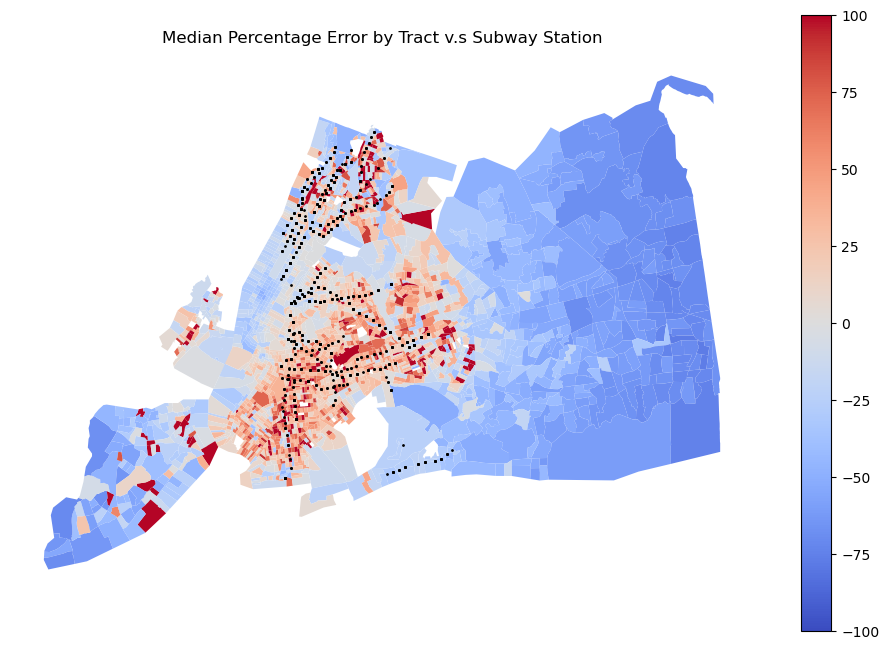

In [90]:
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named error_by_tract
min_legend_value = -100  # Set the minimum value for the legend
max_legend_value = 100  # Set the maximum value for the legend

# Plot the GeoDataFrame with legend
ax = error_by_tract2.plot(column='med_pct_error', cmap='coolwarm', legend=True, figsize=(12, 8), vmin=min_legend_value, vmax=max_legend_value)

# Plot subway stations
station2.plot(marker='o', color='black', markersize=1, ax=ax)

# Hide coordinate system axes
ax.set_axis_off()

plt.title('Median Percentage Error by Tract v.s Subway Station')
plt.show()


## 5. Conclusion

Overall, though remaining a few flaws in our model, we still believe that this model will show the corelation between the selected features and OD distance.These features could be utilized by the government for:

- **Improve Transportation:** Enhance public transport or roads where needed.

- **Plan Cities Wisely:** Work with urban planners to arrange living and working spaces more efficiently.

- **Involve the Community:** Understand what people want and involve them in decisions.

- **Use Data Smartly:** Keep improving the model with more information to make better predictions.

- **Check Results:** Regularly see if changes are making a positive impact and adjust as needed.